In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and preprocess the data
df = pd.read_csv("aapl_2014_2023.csv")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [35]:
# Feature engineering
df['next_day_close_price'] = df['close'].shift(-1)
df = df.dropna().reset_index(drop=True)

# Define features and target
features = df.drop(columns=['date', 'year', 'next_day_close_price'])
target = df['next_day_close_price']

# Identify numeric and non-numeric features
numeric_features = features.select_dtypes(include=[np.number])
categorical_features = features.select_dtypes(exclude=[np.number])

# One-hot encode non-numeric features
categorical_features_encoded = pd.get_dummies(categorical_features)

# Combine numeric and encoded categorical features
features_preprocessed = pd.concat([numeric_features, categorical_features_encoded], axis=1)

# Convert to float64 to ensure compatibility
features_preprocessed = features_preprocessed.astype(np.float64)

# Normalize numeric features
scaler = MinMaxScaler()
features_preprocessed[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [36]:
# Convert to numpy arrays for ADMM processing and split the data
X = features_preprocessed.values
y = target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ADMM parameters
lambda_param = 1.0  # Regularization parameter for Lasso
rho = 1.0           # Penalty parameter for ADMM
max_iter = 1000     # Maximum number of iterations
tol = 1e-4          # Convergence tolerance

# ADMM Lasso function
def admm_lasso(X, y, lambda_param, rho, max_iter, tol):
    m, n = X.shape
    beta = np.zeros(n)     # Initialize beta coefficients
    z = np.zeros(n)        # Auxiliary variable z
    u = np.zeros(n)        # Dual variable u

    XTX = X.T @ X
    XTy = X.T @ y
    I = np.eye(n)

    for iteration in range(max_iter):
        # Update beta
        beta = np.linalg.inv(XTX + rho * I) @ (XTy + rho * (z - u))

        # Update z with soft-thresholding
        z_old = z
        z = np.sign(beta + u) * np.maximum(0, np.abs(beta + u) - lambda_param / rho)

        # Update dual variable u
        u += beta - z

        # Check convergence
        if np.linalg.norm(z - z_old, ord=2) < tol:
            print(f"Convergence reached at iteration {iteration}")
            break

    return beta


In [37]:
# Fit the model
beta_admm = admm_lasso(X_train, y_train, lambda_param, rho, max_iter, tol)

# Predict on the test set
y_pred = X_test @ beta_admm

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R-squared: {r2}")

# Output feature importances (non-zero coefficients)
feature_importances = {col: coef for col, coef in zip(features_preprocessed.columns, beta_admm) if coef != 0}
print("Selected Features and Coefficients:", feature_importances)

Convergence reached at iteration 242
Mean Squared Error: 1.5542782793938772
Mean Absolute Error (MAE): 0.8088259386618895
Mean Absolute Percentage Error (MAPE): 1.4898650738221961%
R-squared: 0.9995146630153076
Selected Features and Coefficients: {'open': -1.736562645067647e-06, 'high': -2.2479198917094536e-06, 'low': -2.2860834788757923e-06, 'close': 174.1108717087241, 'volume': 0.62659525592067, 'rsi_7': -0.3628214524070323, 'rsi_14': 0.015949278036553653, 'cci_7': -0.06495924626534336, 'cci_14': 0.6611541467475783, 'sma_50': -6.349684625781599e-07, 'ema_50': 1.5979787675656735e-07, 'sma_100': 0.605765451901586, 'ema_100': 1.7280775889325812, 'macd': 1.1258156376632056, 'bollinger': 3.948083555951469, 'TrueRange': -1.1263005554022607, 'atr_7': 3.0452298158064676e-06, 'atr_14': 0.3104082123520767, 'target_bearish': 15.64582573615641, 'target_bullish': 18.469808863280225, 'target_neutral': 17.1027390315898}


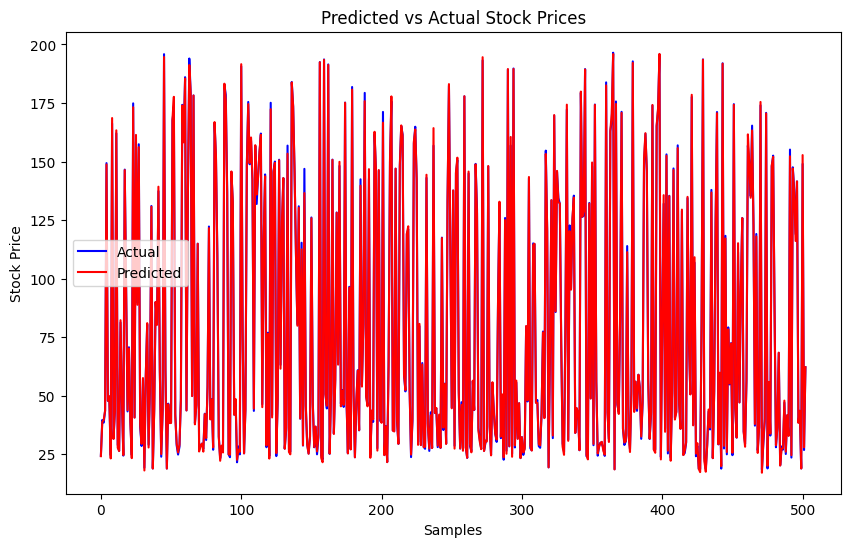

In [38]:
# Visualising Predictions vs. Actual Values

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="red")
plt.xlabel("Samples")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Predicted vs Actual Stock Prices")
plt.show()

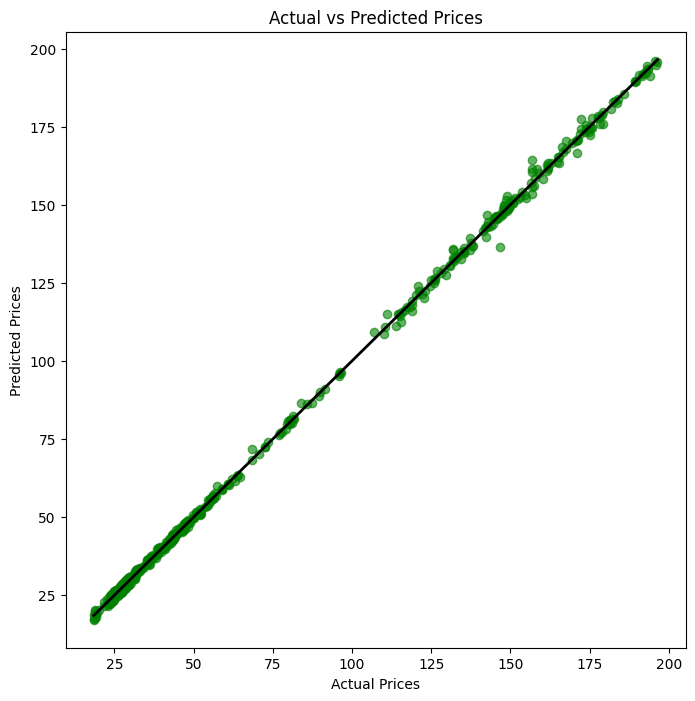

In [40]:
# Scatter Plot of Actual vs. Predicted Values

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color="green")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="black", lw=2)
plt.show()

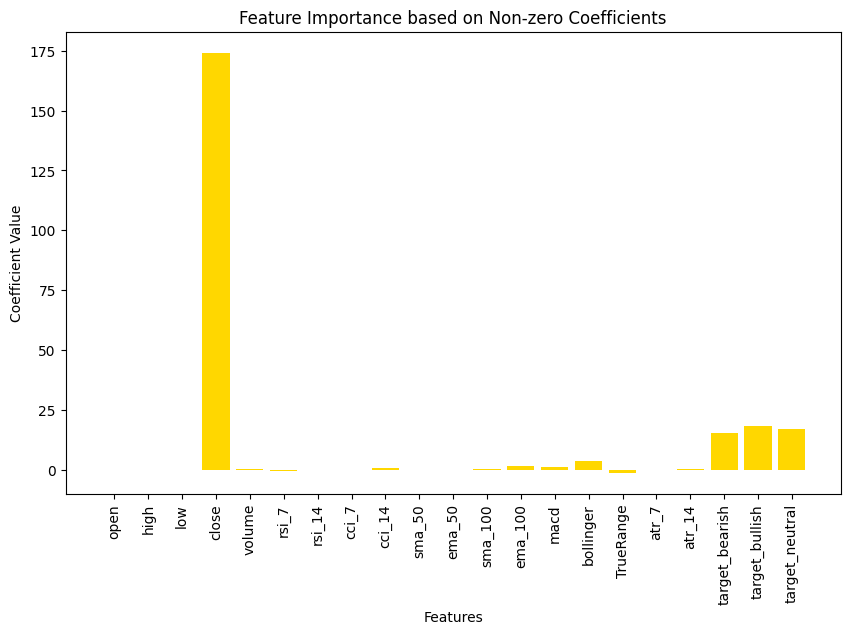

In [47]:
# Feature Importance Analysis

# Plot non-zero coefficients
non_zero_coefs = {k: v for k, v in feature_importances.items() if v != 0}

plt.figure(figsize=(10, 6))
plt.bar(non_zero_coefs.keys(), non_zero_coefs.values(), color="gold")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.title("Feature Importance based on Non-zero Coefficients")
plt.show()